In [2]:
import wikipedia
import urllib.request as req
import re
from os import listdir, rename, path
import matplotlib.pyplot as plt
import cairosvg
import imutils
import cv2
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
from matplotlib.colors import hsv_to_rgb

# Function and parameters definition
I defined following functions used to perform flag regonition. Function are described above next cells.
Also thresholds for colours have been defined here.

In [3]:
ratio = 255/180
lower_black = (int(0 * ratio), 0, 0)
upper_black = (int(180 * ratio), 255, 40)

lower_pink_red = (120 * ratio, 40, 40)
upper_pink_red = (180 * ratio, 255, 255)
lower_orange_red = (0 * ratio, 40, 40)
upper_orange_red = (15 * ratio, 255, 255)

lower_yellow = (15 * ratio, 40, 40)
upper_yellow = (40 * ratio, 255, 255)

lower_green = (40 * ratio, 40, 40)
upper_green = (70 * ratio, 255, 255)

lower_blue = (70 * ratio, 40, 40)
upper_blue = (120 * ratio, 255, 255)

lower_white = (0 * ratio, 0, 200)
upper_white = (180 * ratio, 30, 255)

def flags_prep(svg_flags_dir = 'svg_flags', png_flags_dir = 'png_flags'):
    if len(listdir(svg_flags_dir)) == 206 and len(listdir(png_flags_dir)) == 206:
        print('Please continue, flags have been already prepared.')
    elif len(listdir(svg_flags_dir)) != 0 or len(listdir(png_flags_dir)) != 0: 
        print('Please delete old elements first!')
    else:
        flags = wikipedia.page("Gallery of sovereign state flags")
        img_links = list(dict.fromkeys([ x for x in flags.images if "Flag_of_" in x ]))
        for imageurl in img_links:
            country_name = re.search(r"F.*\.svg$", imageurl).group(0)
            req.urlretrieve(imageurl, path.join(svg_flags_dir, country_name))
        to_rename = [ flag for flag in listdir(svg_flags_dir) if '%' in flag]
        for flag in to_rename:
            if flag == 'Flag_of_Australia_%28converted%29.svg':
                rename(path.join(svg_flags_dir, flag), path.join(svg_flags_dir, 'Flag_of_Australia.svg'))
            elif flag == 'Flag_of_Belgium_%28civil%29.svg':
                rename(path.join(svg_flags_dir, flag), path.join(svg_flags_dir, 'Flag_of_Belgium.svg'))
            elif flag == 'Flag_of_C%C3%B4te_d%27Ivoire.svg':
                rename(path.join(svg_flags_dir, flag), path.join(svg_flags_dir, 'Flag_of_Ivory_Coast.svg'))
            elif flag == 'Flag_of_Canada_%28Pantone%29.svg':
                rename(path.join(svg_flags_dir, flag), path.join(svg_flags_dir, 'Flag_of_Canada.svg'))
            elif flag == 'Flag_of_the_People%27s_Republic_of_China.svg':
                rename(path.join(svg_flags_dir, flag), path.join(svg_flags_dir, 'Flag_of_China.svg'))
            elif flag == 'Flag_of_Transnistria_%28state%29.svg':
                rename(path.join(svg_flags_dir, flag), path.join(svg_flags_dir, 'Flag_of_Transnistria.svg'))
            else:
                print('I don\'t know how to change ' + flag)
        for svg_flag in listdir(svg_flags_dir):
            try:
                cairosvg.svg2png(url = path.join(svg_flags_dir, svg_flag), write_to = path.join(png_flags_dir, svg_flag.split('.')[0] + '.png'))
            except TypeError as e:
                print("Can't convert " + svg_flag +'\n' + str(e))

                
def get_state_name(flag):
    state = flag.split('Flag_of_')[1].split('.')[0]
    if 'the_' in state: state = state.replace('the_','')
    if 'The_' in state: state = state.replace('The_','')
    return state
                
    
def get_shapes_number(png_flags_dir = 'png_flags'):
    state_name = []
    contours_number = []
    for flag in listdir(png_flags_dir):
        image = cv2.imread(path.join(png_flags_dir, flag))
        image = imutils.resize(image, height = 300)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         gray = cv2.bilateralFilter(gray, 11, 1, 10)
        edged = cv2.Canny(gray, 1, 50)
        edged[:2,:] = 255
        edged[-2:,:] = 255
        edged[:,:2] = 255
        edged[:,-2:] = 255

        cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = np.array(sorted(cnts, key = cv2.contourArea, reverse = True))
        
        state_name.append(get_state_name(flag))
        contours_number.append(len(cnts))
        
    return state_name, contours_number
        
    
def get_colours(png_flags_dir = 'png_flags'):
    
    df['colour_number'] = 0
    df['black'] = 0
    df['black'] = df['black'].astype(object)
    df['red'] = 0
    df['red'] = df['red'].astype(object)
    df['yellow'] = 0
    df['yellow'] = df['yellow'].astype(object)
    df['green'] = 0
    df['green'] = df['green'].astype(object)
    df['blue'] = 0
    df['blue'] = df['blue'].astype(object)
    df['white'] = 0
    df['white'] = df['white'].astype(object)
    
    for flag in listdir(png_flags_dir):
        image = cv2.imread(path.join(png_flags_dir, flag))
        hsv_image = cv2.resize(image, (450, 300), interpolation = cv2.INTER_AREA)
        hsv_image = cv2.cvtColor(hsv_image, cv2.COLOR_BGR2HSV)

        mask_black = cv2.inRange(hsv_image, lower_black, upper_black)
        mask_pink_red = cv2.inRange(hsv_image, lower_pink_red, upper_pink_red)
        mask_orange_red = cv2.inRange(hsv_image, lower_orange_red, upper_orange_red)
        mask_red = mask_pink_red + mask_orange_red
        mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
        mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
        mask_blue = cv2.inRange(hsv_image, lower_blue, upper_blue)
        mask_white = cv2.inRange(hsv_image, lower_white, upper_white)
        
        state_name = get_state_name(flag)
        colours = np.array([mask_black, mask_red, mask_yellow, mask_green, mask_blue, mask_white])
        colour_counter = 0
        for colour in colours:
            if colour.any() == True: colour_counter = colour_counter + 1
            else: continue
        df.at[state_name, 'colour_number'] = colour_counter

        df.at[state_name, 'black'] = mask_black
        df.at[state_name, 'red'] = mask_red
        df.at[state_name, 'yellow'] = mask_yellow
        df.at[state_name, 'green'] = mask_green
        df.at[state_name, 'blue'] = mask_blue
        df.at[state_name, 'white'] = mask_white
        
    df['colour_number'] = df['colour_number'].astype('int32')

    
def get_flag_clrs(flag_path):
   
    image = cv2.imread(flag_path)
    hsv_image = cv2.resize(image, (450, 300), interpolation = cv2.INTER_AREA)
    hsv_image = cv2.cvtColor(hsv_image, cv2.COLOR_BGR2HSV)

    mask_black = cv2.inRange(hsv_image, lower_black, upper_black)
    mask_pink_red = cv2.inRange(hsv_image, lower_pink_red, upper_pink_red)
    mask_orange_red = cv2.inRange(hsv_image, lower_orange_red, upper_orange_red)
    mask_red = mask_pink_red + mask_orange_red
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
    mask_blue = cv2.inRange(hsv_image, lower_blue, upper_blue)
    mask_white = cv2.inRange(hsv_image, lower_white, upper_white)

    colours = np.array([mask_black, mask_red, mask_yellow, mask_green, mask_blue, mask_white])
    colour_counter = 0
    for colour in colours:
        if colour.any() == True: colour_counter = colour_counter + 1
        else: continue
    return colours

# Flags preparation
Function flags_prep() downloads flags from Wikipedia and saves they to 'svg_flags' directory (should exists). Next it converts each flag which have been download with .svg extension to .png format and saves to 'png_flags' directory (should exists). 'png_flags' is by default base directory for further operations perforemd by other functions.

WARNING! cairosvg tool, which I used to perform conversion from .svg to .png cannot convert a few flags:
Flag_of_Croatia
Flag_of_Guatemala
Flag_of_Malta
Flag_of_Mexico
Flag_of_Moldova
Flag_of_Montenegro
Flag_of_Nicaragua
Flag_of_Portugal

That's why I manualy prepared these flags using external converter. I think that to properly convert each flag to .png is not the main part of the task.

If .svg and .png files have been found by function in proper directory, the function will do nothing and return 'Please continue, flags have been already prepared.' information.

In [3]:
flags_prep()

Please continue, flags have been already prepared.


# Dataframe preparation
Function get_shapes_number() will take each flag and calculate number of contours existing on flag. At first I wanted to recognize flags by comparing contours number and contours shape by it failed. This function will provide number of contours and the country name for each flag.

Then, using this two values we will create pandas dataframe, where country name will be an index.

After all we call get_colours() function, which calculates for each flag number of colours (max 6: black, white, red, green, blue, yellow) and mask array for each colour.

In [4]:
state_name, contours_number = get_shapes_number()
df = pd.DataFrame(contours_number, columns=['contours_number'], index=state_name)
get_colours()

# Colours comparison
First of all we call function get_flag_clrs(path_to_flag). Here we can specify which flag we would like to recognize.
#### ONLY .png files are allowed. You can also change .jpg or .jpeg extension to .png but .gif and .svg ARE NOT ALLOWED.

For selected flag we calculate mask array for each colour (black, white, yellow, green, red, blue) and compare these arrays with arrays for each flag stored in dataframe by calculating Mean Squared Error. Then we take sum of MSEs calculated for 6 colours and this sum of MSEs is our metric. We store this metrin in 'mse' column in dataframe.

In [5]:
colours = get_flag_clrs('poland-hi.png')
df['mse'] = 100.0
for index, row in df.iterrows():
    mses = np.empty(6)
    mse_sum = 0
    clrs = np.array(df.loc[index][2:8])
    for clr in range(len(clrs)):
        mses[clr] = ((clrs[clr] - colours[clr])**2).mean()
        mse_sum = mse_sum + mses[clr]
    df.at[index, 'mse'] = mse_sum

# Flag recognition
Finally we take minimal value from column 'mse' and country name which this value corresponds to.
At the end we print country name and sum MSEs.

In [6]:
response = min(df['mse'])
row = df.loc[df['mse'] == response]
flag_country_name = row['mse'].index.values[0]
print("This is " + flag_country_name + ' flag with MSE: ' + str(row['mse'].values[0]))

This is Sweden flag with MSE: 0.015200000000000002


### If the answer given in cell above is wrong we can check how big is the mistake.
Below we can just enter proper country name in quotes and check sum MSE for it.

In [7]:
df.loc[['Turkish_Republic_of_Northern_Cyprus']]

,contours_number,colour_number,black,red,yellow,green,blue,white,mse
Turkish_Republic_of_Northern_Cyprus,10,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",1.799593


# Preparation to visualization
Below I will obtain country list for each continent. I assumed that countries classified in Wikipedia for both Europe and Asia will be treated as Asian countries: Russia, Armenia, Georgia, Cyprus, Azerbaijan, Turkey etc.

In [8]:
africa = wikipedia.page("Flags of Africa")
asia = wikipedia.page("Flags of Asia")
europe = wikipedia.page("Flags of Europe")
north_america = wikipedia.page("Flags of North America")
south_america = wikipedia.page("Flags of South America")
oceania = wikipedia.page("Flags of Oceania")


africa_countries = []
asia_countries = []
europe_countries = []
north_america_countries = []
south_america_countries = []
oceania_countries = []

for country in africa.links:
    if 'Flag of' not in country: 
        del(country)
        continue
    if ' ' in country: country = country.replace(' ', '_')
    country = country.split('Flag_of_')[1].split('.')[0]
    if 'the_' in country: country = country.replace('the_','')
    if country == 'São_Tomé_and_Príncipe': country = 'Sao_Tome_and_Principe'
    africa_countries.append(country)

for country in asia.links:
    if 'Flag of' not in country: 
        del(country)
        continue
    if ' ' in country: country = country.replace(' ', '_')
    country = country.split('Flag_of_')[1].split('.')[0]
    if 'the_' in country: country = country.replace('the_','')
    if country == 'Georgia_(country)': country = 'Georgia'
    if country == 'Abkhazia': country = 'Republic_of_Abkhazia'
    if country == 'Northern_Cyprus': country = 'Turkish_Republic_of_Northern_Cyprus'
    if country == 'Republic_of_Artsakh': country = 'Artsakh'
    asia_countries.append(country)
    
for country in europe.links:
    if 'Flag of' not in country: 
        del(country)
        continue
    if ' ' in country: country = country.replace(' ', '_')
    country = country.split('Flag_of_')[1].split('.')[0]
    if 'the_' in country: country = country.replace('the_','')
    if country in asia_countries: 
        del(country)
        continue
    europe_countries.append(country)
    
for country in north_america.links:
    if 'Flag of' not in country: 
        del(country)
        continue
    if ' ' in country: country = country.replace(' ', '_')
    country = country.split('Flag_of_')[1].split('.')[0]
    if 'the_' in country: country = country.replace('the_','')
    north_america_countries.append(country)
    
for country in south_america.links:
    if 'Flag of' not in country: 
        del(country)
        continue
    if ' ' in country: country = country.replace(' ', '_')
    country = country.split('Flag_of_')[1].split('.')[0]
    if 'the_' in country: country = country.replace('the_','')
    south_america_countries.append(country)
    
for country in oceania.links:
    if 'Flag of' not in country: 
        del(country)
        continue
    if ' ' in country: country = country.replace(' ', '_')
    country = country.split('Flag_of_')[1].split('.')[0]
    if 'the_' in country: country = country.replace('the_','')
    oceania_countries.append(country)

# Continent assigment
Here I fill new column in dataframe called 'continent' with the name of continent obtained from wikipedia.

In [9]:
df['continent'] = 'World'
df['continent'] = df['continent'].astype(object)
for country in africa_countries:
    if country in df.index.values:
        df.at[country, 'continent'] = 'Africa'
for country in asia_countries:
    if country in df.index.values:
        df.at[country, 'continent'] = 'Asia'
for country in europe_countries:
    if country in df.index.values:
        df.at[country, 'continent'] = 'Europe'
for country in north_america_countries:
    if country in df.index.values:
        df.at[country, 'continent'] = 'North America'
for country in south_america_countries:
    if country in df.index.values:
        df.at[country, 'continent'] = 'South America'
for country in oceania_countries:
    if country in df.index.values:
        df.at[country, 'continent'] = 'Oceania'

# Visualization part 1
Scatter plot which shows space of the flags in two dimensions. Dimension 1 is number of colours, dimension 2 number of contours.

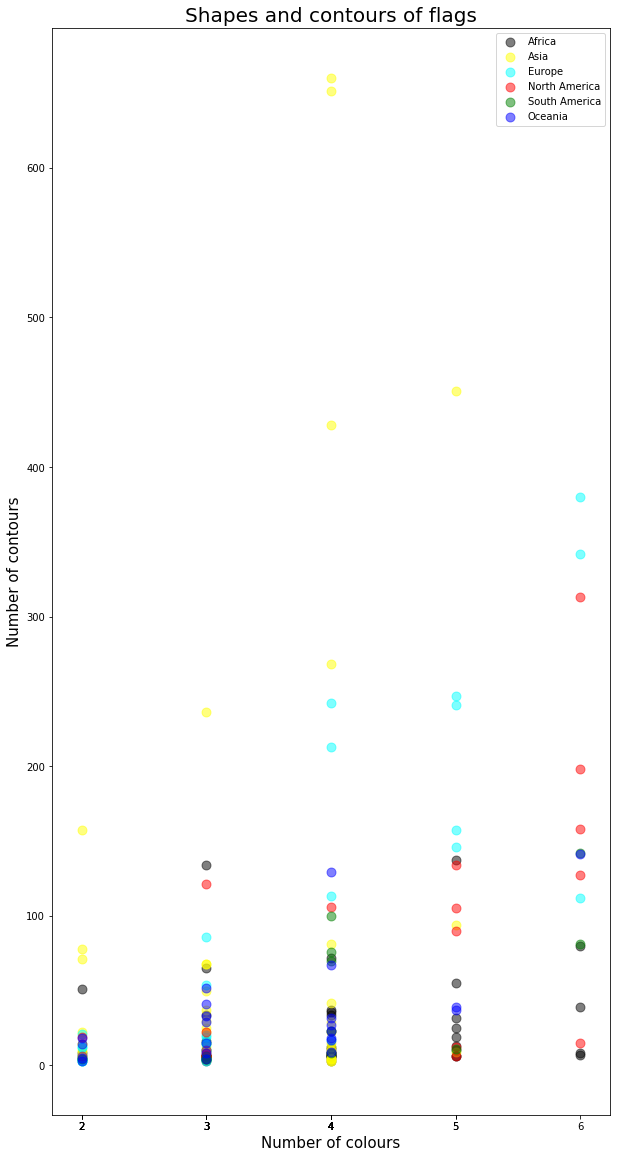

<Figure size 1440x1280 with 0 Axes>

In [10]:
afr = df.loc[df['continent'] == 'Africa']
asi = df.loc[df['continent'] == 'Asia']
eur = df.loc[df['continent'] == 'Europe']
nam = df.loc[df['continent'] == 'North America']
sam = df.loc[df['continent'] == 'South America']
oce = df.loc[df['continent'] == 'Oceania']


plt.rcParams['figure.figsize'] = [10, 20]

fig, ax = plt.subplots()
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i, cont, cont_name in [['black', afr, 'Africa'], ['yellow', asi, 'Asia'], ['cyan', eur, 'Europe'], ['red', nam, 'North America'], ['green', sam, 'South America'], ['blue', oce, 'Oceania']]:
    x = cont['colour_number'].values
    y = cont['contours_number'].values
    ax.scatter(x, y, c=i, s=80, label = cont_name, alpha = 0.5)

ax.set_xticks(x)
ax.set_xlabel('Number of colours', fontsize=15)
ax.set_ylabel('Number of contours', fontsize=15)
ax.set_title('Shapes and contours of flags', fontsize=20)
ax.legend()
plt.show()


# Visualization part 2
Flags space reduced to contours number < 130.

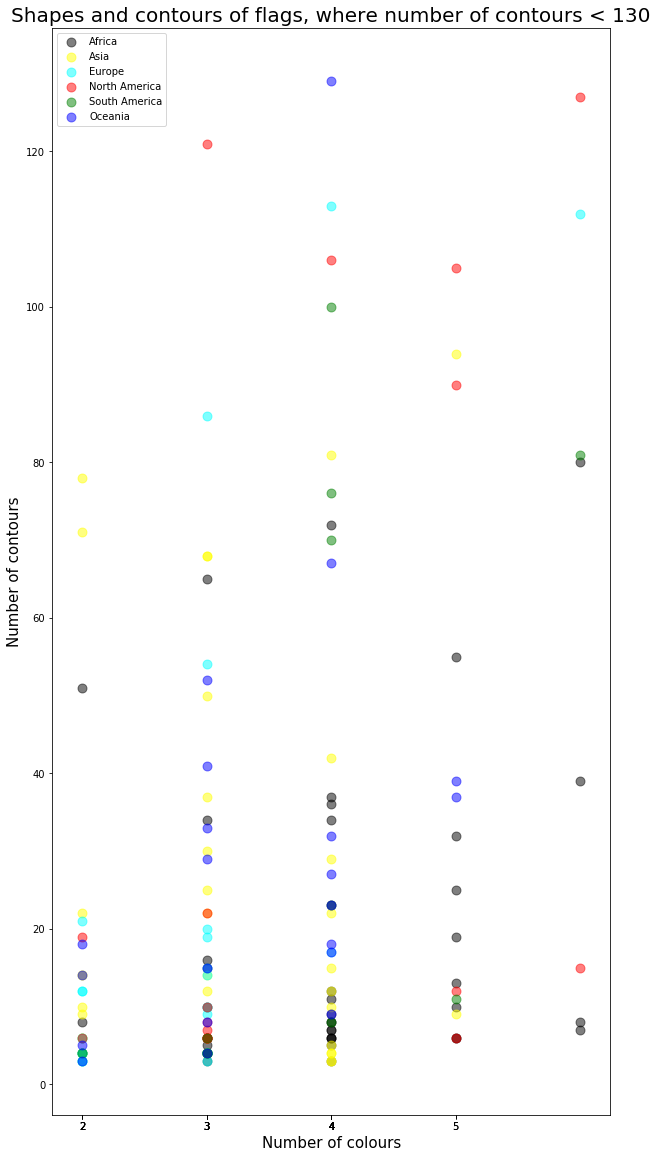

<Figure size 1440x1280 with 0 Axes>

In [11]:
rows = df.loc[df['contours_number'] < 130]
afr = rows.loc[df['continent'] == 'Africa']
asi = rows.loc[df['continent'] == 'Asia']
eur = rows.loc[df['continent'] == 'Europe']
nam = rows.loc[df['continent'] == 'North America']
sam = rows.loc[df['continent'] == 'South America']
oce = rows.loc[df['continent'] == 'Oceania']


plt.rcParams['figure.figsize'] = [10, 20]

fig, ax = plt.subplots()
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i, cont, cont_name in [['black', afr, 'Africa'], ['yellow', asi, 'Asia'], ['cyan', eur, 'Europe'], ['red', nam, 'North America'], ['green', sam, 'South America'], ['blue', oce, 'Oceania']]:
    x = cont['colour_number'].values
    y = cont['contours_number'].values
    ax.scatter(x, y, c=i, s=80, label = cont_name, alpha = 0.5)

ax.set_xticks(x)
ax.set_xlabel('Number of colours', fontsize=15)
ax.set_ylabel('Number of contours', fontsize=15)
ax.set_title('Shapes and contours of flags, where number of contours < 130', fontsize=20)
ax.legend()
plt.show()

# Visualization part 3
Flags space reduced to contours number < 40.

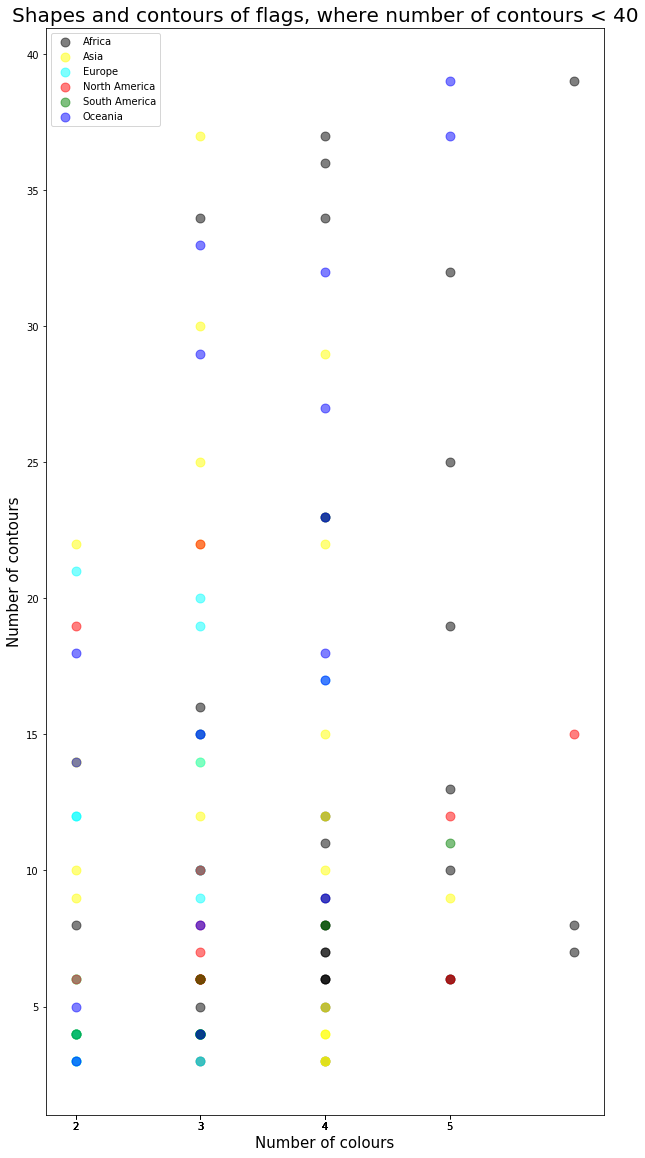

<Figure size 1440x1280 with 0 Axes>

In [12]:
rows = df.loc[df['contours_number'] < 40]
afr = rows.loc[df['continent'] == 'Africa']
asi = rows.loc[df['continent'] == 'Asia']
eur = rows.loc[df['continent'] == 'Europe']
nam = rows.loc[df['continent'] == 'North America']
sam = rows.loc[df['continent'] == 'South America']
oce = rows.loc[df['continent'] == 'Oceania']


plt.rcParams['figure.figsize'] = [10, 20]

fig, ax = plt.subplots()
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i, cont, cont_name in [['black', afr, 'Africa'], ['yellow', asi, 'Asia'], ['cyan', eur, 'Europe'], ['red', nam, 'North America'], ['green', sam, 'South America'], ['blue', oce, 'Oceania']]:
    x = cont['colour_number'].values
    y = cont['contours_number'].values
    ax.scatter(x, y, c=i, s=80, label = cont_name, alpha=0.5)

ax.set_xticks(x)
ax.set_xlabel('Number of colours', fontsize=15)
ax.set_ylabel('Number of contours', fontsize=15)
ax.set_title('Shapes and contours of flags, where number of contours < 40', fontsize=20)
ax.legend()
plt.show()

# Continent - colours relationship
If any pixel of the flag contains specific color, set 1, else set 0.

In [13]:
clrs_list = ['black', 'red', 'yellow', 'green', 'blue', 'white']
for index, row in df.iterrows():
    for clr in df[clrs_list]:
        if df.loc[index, clr].any() == True:
            df.at[index, clr] = 1
        else:
            df.at[index, clr] = 0

### Sub-dataframe for each continent

In [14]:
afr = df.loc[df['continent'] == 'Africa']
asi = df.loc[df['continent'] == 'Asia']
eur = df.loc[df['continent'] == 'Europe']
nam = df.loc[df['continent'] == 'North America']
sam = df.loc[df['continent'] == 'South America']
oce = df.loc[df['continent'] == 'Oceania']

### Counting colors for each continent

In [15]:
def colours_counter(continent):
    clrs_list = ['black', 'red', 'yellow', 'green', 'blue', 'white']
    black_counter = 0
    red_counter = 0
    yellow_counter = 0
    green_counter = 0
    blue_counter = 0
    white_counter = 0
    for index, row in continent.iterrows():
        for clr in continent[clrs_list]:
            if df.loc[index, clr] == 1:
                if clr == 'black': black_counter = black_counter + 1
                elif clr == 'red': red_counter = red_counter + 1
                elif clr == 'yellow': yellow_counter = yellow_counter + 1
                elif clr == 'green': green_counter = green_counter + 1
                elif clr == 'blue': blue_counter = blue_counter + 1
                else: white_counter = white_counter + 1
            else:
                continue
    counters = [black_counter, red_counter, yellow_counter, green_counter, blue_counter, white_counter]
    return counters

In [16]:
afr_counters = colours_counter(afr)
asi_counters = colours_counter(asi)
eur_counters = colours_counter(eur)
nam_counters = colours_counter(nam)
sam_counters = colours_counter(sam)
oce_counters = colours_counter(oce)    

### Ploting results 

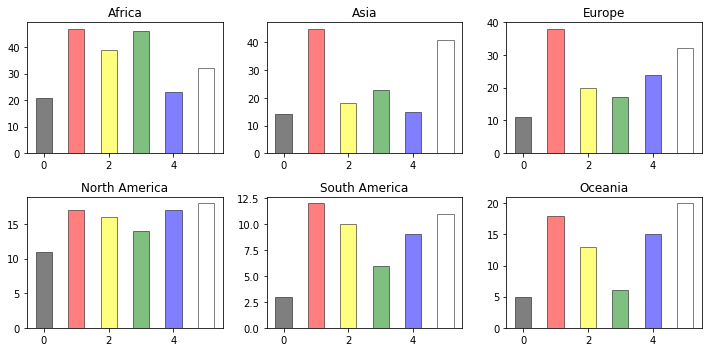

In [17]:
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot2grid((2,3), (0,0)) 
ax2 = plt.subplot2grid((2,3), (0,1)) 
ax3 = plt.subplot2grid((2,3), (0,2)) 
ax4 = plt.subplot2grid((2,3), (1,0)) 
ax5 = plt.subplot2grid((2,3), (1,1)) 
ax6 = plt.subplot2grid((2,3), (1,2)) 
clrs_list = ['black', 'red', 'yellow', 'green', 'blue', 'white']

y1 = afr_counters
x1 = range(len(y1))
ax1.bar(x1, y1, align="center", width=0.5, alpha=0.5, color = clrs_list, edgecolor='black')
ax1.set_title("Africa")

y2 = asi_counters
x2 = range(len(y2))
ax2.bar(x2, y2, align="center", width=0.5, alpha=0.5, color = clrs_list, edgecolor='black')
ax2.set_title("Asia")

y3 = eur_counters
x3 = range(len(y3))
ax3.bar(x3, y3, align="center", width=0.5, alpha=0.5, color = clrs_list, edgecolor='black')
ax3.set_title("Europe")

y4 = nam_counters 
x4 = range(len(y4))
ax4.bar(x4, y4, align="center", width=0.5, alpha=0.5, color = clrs_list, edgecolor='black')
ax4.set_title("North America")

y5 = sam_counters
x5 = range(len(y5))
ax5.bar(x5, y5, align="center", width=0.5, alpha=0.5, color = clrs_list, edgecolor='black')
ax5.set_title("South America")

y6 = oce_counters
x6 = range(len(y6))
ax6.bar(x6, y6, align="center", width=0.5, alpha=0.5, color = clrs_list, edgecolor='black')
ax6.set_title("Oceania")
fig.tight_layout()

# Continent - colours relationship summary
### Asia and Europe
Mainly use red and white colour.
### Africa
The most popular colours are red, yellow, and green.
### Oceania and South America
Most populars are white and red, but yellow and blue are also often used. Green is almost least popular colour.
### North America
There most popular are red and white but there is no big difference between them and other colours.
##### Black
Least popular colour at each continent. Biggest number of uses among African flags.
##### Red
Most popular in Africa, Asia, Europe, South America. In Oceania and North Amercia secend most popular.
##### Green and yellow
Most often used in Africa, Asia and Europe.
##### Blue
Frequently used in Africa, Europe and North America.